# Train AE with data generated on MullerBrown potential 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [4]:
pot = MullerBrown()

In [5]:
beta = 0.05
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**7

In [6]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

KeyboardInterrupt: 

In [7]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [8]:
trajs = np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)
np.savetxt('dataset_MB.txt', trajs)

In [7]:
## fix the random seed to subsample the dataset and for torch 
import torch 
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)
trajs = np.loadtxt('dataset_MB.txt')
trajs = trajs[np.random.choice(len(trajs), size=2 * 10**5)]
react_approx_density = np.loadtxt("mullerbrown_react_dens.txt")
react_approx_density = react_approx_density[np.random.choice(len(react_approx_density), size=2 * 10**5)]

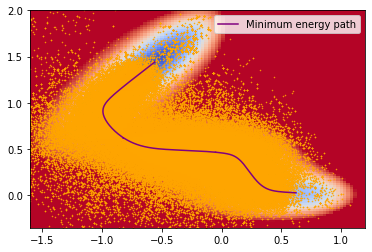

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
#ax.scatter(trajs[:, 0], trajs[:, 1], marker=".", color="orange", s=1)
ax.scatter(react_approx_density[:, 0], react_approx_density[:, 1], marker=".", color="orange", s=1)
ax.legend()

In [9]:
dataset = {"boltz_points": trajs, "react_points":react_approx_density}

In [10]:
dataset.keys()

dict_keys(['boltz_points', 'react_points'])

Import AE model 

In [11]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.train_aes import TainAEOneDecoder

Create autoencoder object

In [58]:
del(ae)
del(ae_training)

Fix the torch random seed

In [59]:
seed = 6   ## Seed 6 leads to the "wrong solution" Seed 2 is really good: visually close to MEP 
set_all_seeds(seed)
ae = DeepAutoEncoder([2, 5, 5, 1], [1, 20, 20, 2], 0)

Created training object

In [60]:
ae_training = TainAEOneDecoder(ae, pot, dataset.copy(), standardize=False, zca_whiten=False)

Set the training size and do the train-test split

In [61]:
ae_training.train_test_split(train_size=2 * 10**4)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)

Set the optimizer 

In [62]:
ae_training.set_optimizer('Adam', 0.005)

Set the loss function parameters 

In [63]:
loss_params = {}
loss_params["mse_boltz_weight"] = 0.0625 * 10**(0)
loss_params["mse_react_weight"] = 1.0 * 10**(0)
loss_params["squared_grad_boltz_weight"] = 0. * 10**(-4)
loss_params["var_enc_weight"] = 0. * 10**(0)

loss_params["n_wait"] = 100
ae_training.set_loss_weight(loss_params)

l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0
pen_points_mse_weight value not provided, set to default value of:  0.0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [64]:
batch_size = 500
max_epochs = 10000

Train 

In [65]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 842 epochs.



Plot the evolution of the loss stating from the 100th epoch 

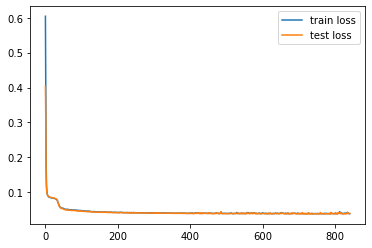

In [66]:
plt.figure()
plt.plot(loss_dict["train_loss"][:], label='train loss')
plt.plot(loss_dict["test_loss"][:], label='test loss')
plt.legend()

Plot the conditionnal averages on the potential heat map 

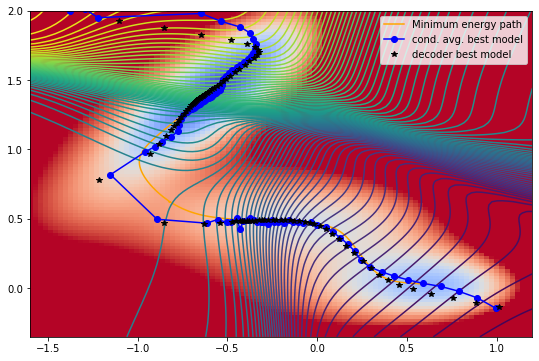

In [67]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
#ax.plot(Esp_X_given_z[:, 0], Esp_X_given_z[:, 1], '-o', color='blue', label='cond. avg. best model')
#ax.plot(f_dec_z[:, 0], f_dec_z[:, 1], '*', color='black', label='decoder best model')
ae_training.plot_encoder_iso_levels(ax, 100)
ae_training.plot_conditional_averages(ax, 100)

ax.legend()

Plot convergence of the principal curve 

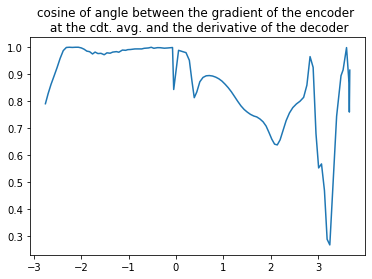

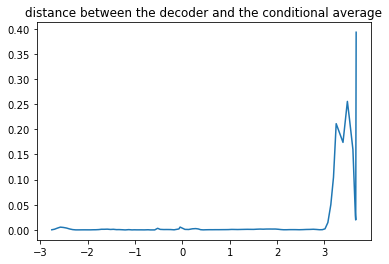

In [68]:
ae_training.plot_principal_curve_convergence(100)

In [69]:
ae_training.print_test_loss()

Test loss:  tensor(0.0396, grad_fn=<AddBackward0>)
Test MSE Boltzmann:  tensor(0.0201, grad_fn=<MeanBackward0>)
Test squarred grad encoder:  tensor(20.6489, grad_fn=<MeanBackward0>)
Test MSE reactive:  tensor(0.0383, grad_fn=<MeanBackward0>)


In [70]:
torch.var(ae_training.test_dataset[:, :2])

tensor(0.8634, grad_fn=<VarBackward0>)